<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

# Auto-load all files
# Mounting drive to avoid manual uploads
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Unzipping the data
# We use -n to avoid overwriting if it already exists
if not os.path.exists('/content/dataset'):
    !unzip -n -q "/content/drive/My Drive/Data" -d "/content/dataset"

In [3]:
# Extract variables
print("Loading CSVs...")
orders = pd.read_csv('/content/dataset/orders.csv')
products = pd.read_csv('/content/dataset/products.csv')
departments = pd.read_csv('/content/dataset/departments.csv')
aisles = pd.read_csv('/content/dataset/aisles.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')
order_products_train = pd.read_csv('/content/dataset/order_products__train.csv')
print("Data loaded.")

Loading CSVs...
Data loaded.


In [4]:
# reducing the memory to allow scalable joins and faster experimentation
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

In [5]:
# Product-Level Features
print("Generating Product Features...")

# Group by product_id to get stats
prods = pd.DataFrame()
prods['orders'] = order_products_prior.groupby(order_products_prior.product_id).size().astype(np.int32)
prods['reorders'] = order_products_prior.groupby(order_products_prior.product_id)['reordered'].sum().astype(np.int32)
prods['reorder_rate'] = (prods['reorders'] / prods['orders']).astype(np.float32)

# Reset index to make product_id a column
products_features = prods.reset_index()

# Clean up
del prods
gc.collect()

print(f"Product features created. Shape: {products_features.shape}")
products_features.head()

Generating Product Features...
Product features created. Shape: (49677, 4)


,product_id,orders,reorders,reorder_rate
0,1,1852,1136,0.613391
1,2,90,12,0.133333
2,3,277,203,0.732852
3,4,329,147,0.446809
4,5,15,9,0.600000


In [6]:
print("\n" + "="*80)
print("ENHANCED PRODUCT----------LEVEL FEATURES")
print("="*80)

# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

# Reload necessary dataframes and re-apply memory reduction
print("Reloading necessary CSVs for feature engineering...")
orders = pd.read_csv('/content/dataset/orders.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')

orders = reduce_mem_usage(orders)
order_products_prior = reduce_mem_usage(order_products_prior)
print("Data reloaded and memory reduced.")

# Recreate products_features as it was deleted in a previous cleanup step
print("Recreating base product features...")
prods = pd.DataFrame()
prods['orders'] = order_products_prior.groupby(order_products_prior.product_id).size().astype(np.int32)
prods['reorders'] = order_products_prior.groupby(order_products_prior.product_id)['reordered'].sum().astype(np.int32)
prods['reorder_rate'] = (prods['reorders'] / prods['orders']).astype(np.float32)
products_features = prods.reset_index()

# Clean up temp var
del prods
gc.collect()
print("Base product features recreated.")

# Add average cart
products_features['avg_cart_position'] = (
    order_products_prior.groupby('product_id')['add_to_cart_order']
    .mean()
    .astype(np.float32)
)

# Add product popularity over time
# Merge with orders to get order_number
product_temporal = order_products_prior.merge(
    orders[['order_id', 'order_number']],
    on='order_id'
)

# Calculate total orders and recent orders
max_order = product_temporal['order_number'].max()
recent_threshold = max_order * 0.75

products_features['total_orders'] = (
    product_temporal.groupby('product_id').size().astype(np.int32)
)

products_features['recent_orders'] = (
    product_temporal[product_temporal['order_number'] >= recent_threshold]
    .groupby('product_id').size().astype(np.int32)
)

# Popularity trend
products_features['popularity_trend'] = (
    (products_features['recent_orders'] / products_features['total_orders'])
    .fillna(0)
    .astype(np.float32)
)

del product_temporal
gc.collect()

print(f"Enhanced product features shape: {products_features.shape}")
products_features.head()


ENHANCED PRODUCT----------LEVEL FEATURES
Reloading necessary CSVs for feature engineering...
Data reloaded and memory reduced.
Recreating base product features...
Base product features recreated.
Enhanced product features shape: (49677, 8)


,product_id,orders,reorders,reorder_rate,avg_cart_position,total_orders,recent_orders,popularity_trend
0,1,1852,1136,0.613391,NaN,NaN,NaN,0.000000
1,2,90,12,0.133333,5.801836,1852.0,41.0,0.022138
2,3,277,203,0.732852,9.888889,90.0,4.0,0.044444
3,4,329,147,0.446809,6.415163,277.0,12.0,0.043321
4,5,15,9,0.600000,9.507599,329.0,NaN,0.000000


In [7]:
#  User-Level Features
print("Generating User Features...")

#  Basic stats from 'orders' table (Total orders, Average days between)
users = orders[orders.eval_set == 'prior'].groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': 'mean'
}).rename(columns={
    'order_number': 'user_total_orders',
    'days_since_prior_order': 'user_avg_days_between_orders'
})

#  Basket stats (Total items, Reorder ratio)
# We need to merge orders with prior products temporarily
user_products_temp = order_products_prior.merge(orders, on='order_id', how='left')

# Group by user to get total items bought and reordered
us = user_products_temp.groupby('user_id').agg({
    'product_id': 'count',
    'reordered': 'mean'
}).rename(columns={
    'product_id': 'user_total_items',
    'reordered': 'user_reorder_ratio'
})

#  Calculate Average Basket Size
us['user_avg_basket_size'] = (us['user_total_items'] / users['user_total_orders']).astype(np.float32)

# Combine A and B
users_features = users.merge(us, on='user_id', how='left').reset_index()

# Clean up massive temp table immediately
del user_products_temp, us, users
gc.collect()

print(f"User features created. Shape: {users_features.shape}")
users_features.head()

Generating User Features...
User features created. Shape: (206209, 6)


,user_id,user_total_orders,user_avg_days_between_orders,user_total_items,user_reorder_ratio,user_avg_basket_size
0,1,10,19.555555,59,0.694915,5.900000
1,2,14,15.230769,195,0.476923,13.928572
2,3,12,12.090909,88,0.625000,7.333333
3,4,5,13.750000,18,0.055556,3.600000
4,5,4,13.333333,37,0.378378,9.250000


In [8]:
print("\n" + "="*80)
print("ENHANCED USER--------LEVEL FEATURES")
print("="*80)

# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

# Reload necessary dataframes and re-apply memory reduction for user features
print("Reloading necessary CSVs for user feature engineering...")
orders = pd.read_csv('/content/dataset/orders.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')

orders = reduce_mem_usage(orders)
order_products_prior = reduce_mem_usage(order_products_prior)
print("Data reloaded and memory reduced.")

# Recreate users_features as it was deleted in a previous cleanup step
print("Recreating base user features...")
#  Basic stats from 'orders' table (Total orders, Average days between)
users = orders[orders.eval_set == 'prior'].groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': 'mean'
}).rename(columns={
    'order_number': 'user_total_orders',
    'days_since_prior_order': 'user_avg_days_between_orders'
})

#  Basket stats (Total items, Reorder ratio)
user_products_temp = order_products_prior.merge(orders, on='order_id', how='left')

us = user_products_temp.groupby('user_id').agg({
    'product_id': 'count',
    'reordered': 'mean'
}).rename(columns={
    'product_id': 'user_total_items',
    'reordered': 'user_reorder_ratio'
})

us['user_avg_basket_size'] = (us['user_total_items'] / users['user_total_orders']).astype(np.float32)

users_features = users.merge(us, on='user_id', how='left').reset_index()

del user_products_temp, us, users
gc.collect()
print("Base user features recreated.")

# Add last order (days since their most recent order)
user_last_order = (
    orders[orders.eval_set == 'prior']
    .sort_values('order_number')
    .groupby('user_id')
    .tail(1)
)

users_features = users_features.merge(
    user_last_order[['user_id', 'days_since_prior_order']].rename(
        columns={'days_since_prior_order': 'user_last_order_days'}
    ),
    on='user_id',
    how='left'
)

users_features['user_last_order_days'] = users_features['user_last_order_days'].fillna(0).astype(np.float32)

print(f"Enhanced user features shape: {users_features.shape}")
users_features.head()


ENHANCED USER--------LEVEL FEATURES
Reloading necessary CSVs for user feature engineering...
Data reloaded and memory reduced.
Recreating base user features...
Base user features recreated.
Enhanced user features shape: (206209, 7)


,user_id,user_total_orders,user_avg_days_between_orders,user_total_items,user_reorder_ratio,user_avg_basket_size,user_last_order_days
0,1,10,19.555555,59,0.694915,5.900000,30.0
1,2,14,15.230769,195,0.476923,13.928572,13.0
2,3,12,12.090909,88,0.625000,7.333333,15.0
3,4,5,13.750000,18,0.055556,3.600000,0.0
4,5,4,13.333333,37,0.378378,9.250000,19.0


In [9]:
# User-Product Interaction Features
print("Generating User-Product Features...")

# Create a merged table of users and products
# We only care about products the user has bought BEFORE (Candidate Generation)
uxp = order_products_prior.merge(orders, on='order_id', how='left')

# Group by [user, product] to get interaction stats
uxp_features = uxp.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count' # How many times user bought this product
}).rename(columns={'order_id': 'uxp_total_bought'})

uxp_features = uxp_features.reset_index()

# Clean up
del uxp
gc.collect()

print(f"User-Product interaction features created. Shape: {uxp_features.shape}")
uxp_features.head()

Generating User-Product Features...
User-Product interaction features created. Shape: (13307953, 3)


,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [10]:
print("\n" + "="*80)
print("ENHANCED USER---------PRODUCT INTERACTION FEATURES")
print("="*80)

# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

# Reload necessary dataframes and re-apply memory reduction
print("Reloading necessary CSVs for user-product feature engineering...")
orders = pd.read_csv('/content/dataset/orders.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')

orders = reduce_mem_usage(orders)
order_products_prior = reduce_mem_usage(order_products_prior)
print("Data reloaded and memory reduced.")

# Recreate uxp_features (User-Product Interaction Features) as it might have been deleted
print("Recreating base User-Product features...")
uxp = order_products_prior.merge(orders, on='order_id', how='left')
uxp_features = uxp.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count' # How many times user bought this product
}).rename(columns={'order_id': 'uxp_total_bought'}).reset_index()
del uxp
gc.collect()
print("Base User-Product features recreated.")

# Merge with orders to get temporal info (NOW INCLUDING user_id)
uxp_temporal = order_products_prior.merge(
    orders[['order_id', 'user_id', 'order_number', 'days_since_prior_order']],
    on='order_id'
)

# Days since last purchase by this user
uxp_last_purchase = (
    uxp_temporal
    .sort_values('order_number')
    .groupby(['user_id', 'product_id'])
    .agg({
        'days_since_prior_order': 'last',
        'order_number': 'last'
    })
    .rename(columns={
        'days_since_prior_order': 'uxp_days_since_last_purchase',
        'order_number': 'uxp_last_order_number'
    })
    .reset_index()
)

uxp_features = uxp_features.merge(
    uxp_last_purchase[['user_id', 'product_id', 'uxp_days_since_last_purchase']],
    on=['user_id', 'product_id'],
    how='left'
)

# Average reorder probability for this user-product

uxp_reorder_rate_df = (
    uxp_temporal.groupby(['user_id', 'product_id'])['reordered']
    .mean()
    .reset_index()
    .rename(columns={'reordered': 'uxp_reorder_rate'})
)
uxp_features = uxp_features.merge(
    uxp_reorder_rate_df,
    on=['user_id', 'product_id'],
    how='left'
)

# Time since first purchase
uxp_first_purchase = (
    uxp_temporal
    .sort_values('order_number')
    .groupby(['user_id', 'product_id'])
    ['order_number']
    .first()
    .reset_index()
    .rename(columns={'order_number': 'uxp_first_order_number'})
)

uxp_features = uxp_features.merge(
    uxp_first_purchase,
    on=['user_id', 'product_id'],
    how='left'
)

del uxp_temporal, uxp_last_purchase, uxp_first_purchase, uxp_reorder_rate_df
gc.collect()

print(f"Enhanced user-product features shape: {uxp_features.shape}")
uxp_features.head()


ENHANCED USER---------PRODUCT INTERACTION FEATURES
Reloading necessary CSVs for user-product feature engineering...
Data reloaded and memory reduced.
Recreating base User-Product features...
Base User-Product features recreated.
Enhanced user-product features shape: (13307953, 6)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,user_id,product_id,uxp_total_bought,uxp_days_since_last_purchase,uxp_reorder_rate,uxp_first_order_number
0,1,196,10,30.0,0.900000,1
1,1,10258,9,30.0,0.888889,2
2,1,10326,1,28.0,0.000000,5
3,1,12427,10,30.0,0.900000,1
4,1,13032,3,30.0,0.666667,2


In [11]:
# Create Master DataFrame
print("Merging all features...")

#  Identify which users we need to predict for (Train/Test sets)
# We look at the 'orders' table to find the last order for each user
distinct_users = orders[orders.eval_set != 'prior'][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

#  Merge with our Candidates (User-Product pairs)
# We perform a Right Join: We want all (User, Product) pairs, but ONLY for the users in distinct_users
data = uxp_features.merge(distinct_users, on='user_id', how='inner')

#  Add User Features
data = data.merge(users_features, on='user_id', how='left')

#  Add Product Features
data = data.merge(products_features, on='product_id', how='left')

print(f"Master features merged. Shape: {data.shape}")
data.head()

Merging all features...
Master features merged. Shape: (13307953, 22)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,user_id,product_id,uxp_total_bought,uxp_days_since_last_purchase,uxp_reorder_rate,uxp_first_order_number,order_id,eval_set,days_since_prior_order,user_total_orders,...,user_reorder_ratio,user_avg_basket_size,user_last_order_days,orders,reorders,reorder_rate,avg_cart_position,total_orders,recent_orders,popularity_trend
0,1,196,10,30.0,0.900000,1,1187899,train,14.0,10,...,0.694915,5.9,30.0,35791,27791,0.776480,6.218750,32.0,NaN,0.0
1,1,10258,9,30.0,0.888889,2,1187899,train,14.0,10,...,0.694915,5.9,30.0,1946,1389,0.713772,14.400000,10.0,NaN,0.0
2,1,10326,1,28.0,0.000000,5,1187899,train,14.0,10,...,0.694915,5.9,30.0,5526,3603,0.652009,7.700000,120.0,NaN,0.0
3,1,12427,10,30.0,0.900000,1,1187899,train,14.0,10,...,0.694915,5.9,30.0,6476,4797,0.740735,6.000000,3.0,NaN,0.0
4,1,13032,3,30.0,0.666667,2,1187899,train,14.0,10,...,0.694915,5.9,30.0,3751,2465,0.657158,6.190476,21.0,NaN,0.0


In [12]:
print("\n" + "="*80)
print("TEMPORAL FEATURE ENGINEERING")
print("="*80)

# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df



# Extract temporal features from the last order for each user
last_orders = orders[orders.eval_set != 'prior'][
    ['user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
]

# Merge into data
data = data.merge(
    last_orders,
    on='user_id',
    how='left',
    suffixes=('', '_last')
)

# Create cyclical encoding for hour
data['hour_sin'] = np.sin(2 * np.pi * data['order_hour_of_day'] / 24).astype(np.float32)
data['hour_cos'] = np.cos(2 * np.pi * data['order_hour_of_day'] / 24).astype(np.float32)

# Day of week cyclical encoding
data['dow_sin'] = np.sin(2 * np.pi * data['order_dow'] / 7).astype(np.float32)
data['dow_cos'] = np.cos(2 * np.pi * data['order_dow'] / 7).astype(np.float32)

# Weekend flag
data['is_weekend'] = (data['order_dow'] >= 5).astype(np.int8)

# Time of day categories
data['time_of_day'] = pd.cut(
    data['order_hour_of_day'],
    bins=[0, 6, 12, 18, 24],
    labels=['night', 'morning', 'afternoon', 'evening'],
    include_lowest=True
)

# Peak hours
data['is_peak_hour'] = ((data['order_hour_of_day'] >= 10) &
                        (data['order_hour_of_day'] <= 16)).astype(np.int8)

print("Temporal features created:")
print(f"  - Cyclical encodings (hour_sin, hour_cos, dow_sin, dow_cos)")
print(f"  - Weekend flag")
print(f"  - Time of day categories")
print(f"  - Peak hour flag")




TEMPORAL FEATURE ENGINEERING
Temporal features created:
  - Cyclical encodings (hour_sin, hour_cos, dow_sin, dow_cos)
  - Weekend flag
  - Time of day categories
  - Peak hour flag


In [13]:
print("\n" + "="*80)
print("WINDOW AGGREGATION FEATURES")
print("="*80)


# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df





# Calculate features over user's last 3 orders
orders_sorted = orders[orders.eval_set == 'prior'].sort_values(['user_id', 'order_number'])

# Last 3 orders for each user
user_last_3 = orders_sorted.groupby('user_id').tail(3)

# Merge with order_products to get items
last_3_products = user_last_3.merge(order_products_prior, on='order_id')

# Calculate stats over last 3 orders
window_features = last_3_products.groupby('user_id').agg({
    'product_id': 'count',
    'reordered': 'mean'
}).rename(columns={
    'product_id': 'user_last3_total_items',
    'reordered': 'user_last3_reorder_rate'
})

# Average basket size in last 3 orders
last_3_basket_sizes = last_3_products.groupby(['user_id', 'order_id']).size()
window_features['user_last3_avg_basket'] = (
    last_3_basket_sizes.groupby('user_id').mean()
)

window_features = window_features.reset_index()

# Merge into main data
data = data.merge(window_features, on='user_id', how='left')

# Fill NaN for users with fewer than 3 orders
data['user_last3_total_items'] = data['user_last3_total_items'].fillna(0).astype(np.float32)
data['user_last3_reorder_rate'] = data['user_last3_reorder_rate'].fillna(0).astype(np.float32)
data['user_last3_avg_basket'] = data['user_last3_avg_basket'].fillna(0).astype(np.float32)

del user_last_3, last_3_products, window_features, last_3_basket_sizes
gc.collect()

print("Window features created over last 3 orders")
print(f"Data shape: {data.shape}")



WINDOW AGGREGATION FEATURES
Window features created over last 3 orders
Data shape: (13307953, 35)


In [14]:
print("\n" + "="*80)
print("NON-LINEAR FEATURE ENGINEERING")
print("="*80)

# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df


# Log transforms (add 1 to avoid log(0))
data['log_uxp_total_bought'] = np.log1p(data['uxp_total_bought']).astype(np.float32)
data['log_user_total_orders'] = np.log1p(data['user_total_orders']).astype(np.float32)
data['log_orders'] = np.log1p(data['orders']).astype(np.float32)

# Square root transforms
data['sqrt_user_total_items'] = np.sqrt(data['user_total_items']).astype(np.float32)

# Interaction terms
data['user_product_interaction'] = (
    data['user_total_orders'] * data['orders']
).astype(np.float32)

data['user_product_reorder_interaction'] = (
    data['user_reorder_ratio'] * data['reorder_rate']
).astype(np.float32)

# Polynomial features (squared)
data['days_since_prior_squared'] = (
    data['days_since_prior_order'] ** 2
).astype(np.float32)

# Ratio features
data['user_product_ratio'] = (
    data['uxp_total_bought'] / (data['user_total_orders'] + 1)
).astype(np.float32)

data['product_user_popularity_ratio'] = (
    data['orders'] / (data['user_total_items'] + 1)
).astype(np.float32)

print("Non-linear features created:")
print(f"  - Log transforms: 3")
print(f"  - Square root transforms: 1")
print(f"  - Interaction terms: 2")
print(f"  - Polynomial features: 1")
print(f"  - Ratio features: 2")
print(f"\nTotal features now: {data.shape[1]}")



NON-LINEAR FEATURE ENGINEERING
Non-linear features created:
  - Log transforms: 3
  - Square root transforms: 1
  - Interaction terms: 2
  - Polynomial features: 1
  - Ratio features: 2

Total features now: 44



OUTLIER DETECTION & TREATMENT
days_since_prior_order: 0 outliers detected (0.00%)
user_total_orders: 653882 outliers detected (4.91%)
user_avg_days_between_orders: 0 outliers detected (0.00%)
user_total_items: 760306 outliers detected (5.71%)
uxp_total_bought: 2091509 outliers detected (15.72%)


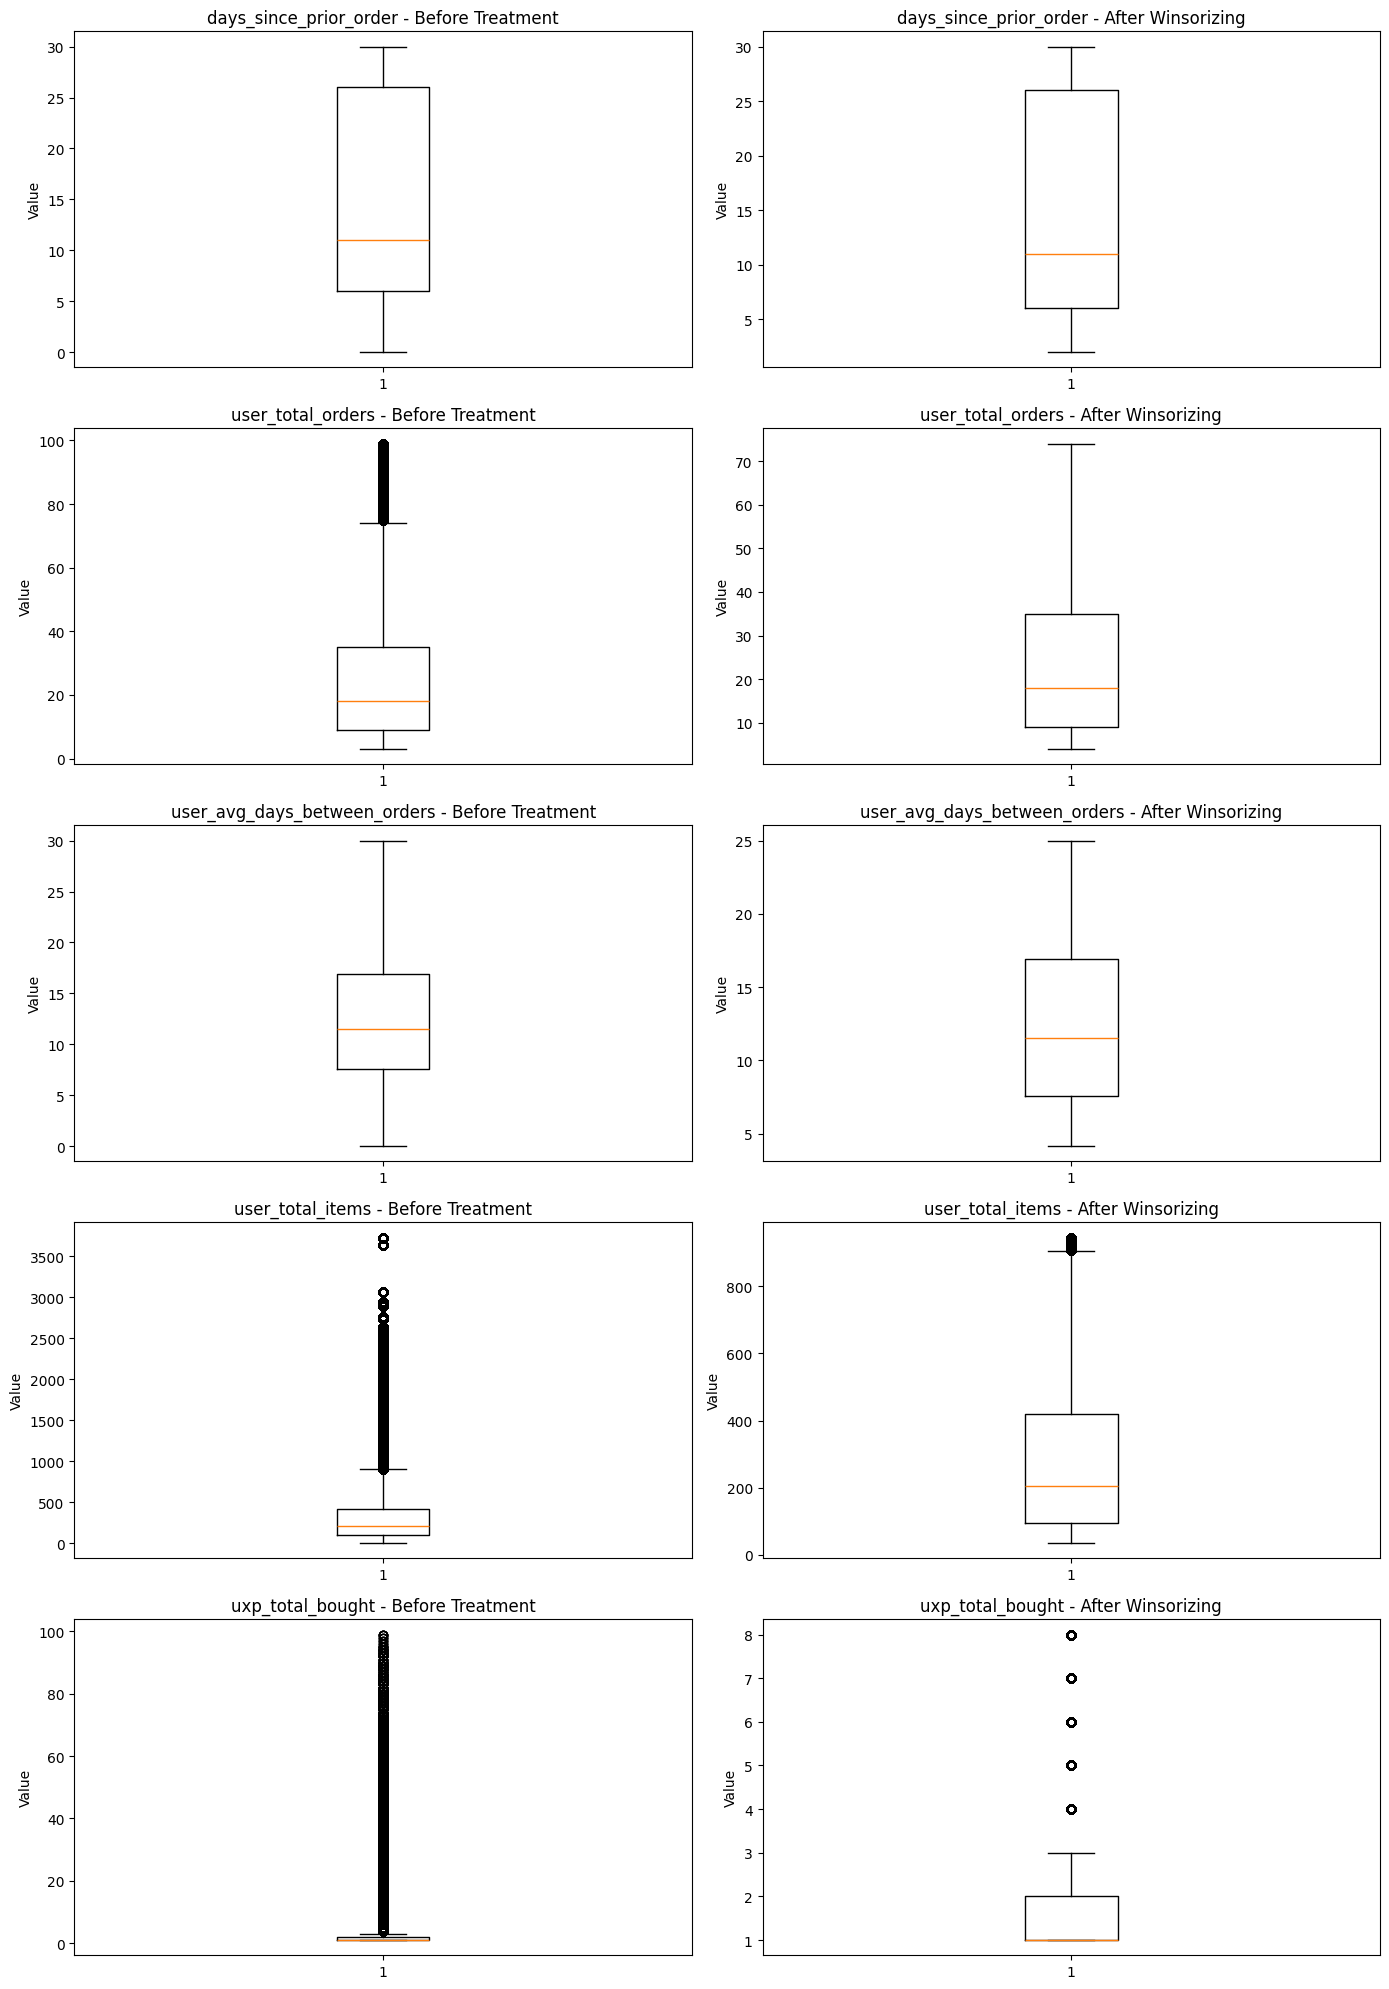


Outlier treatment complete. New winsorized columns created.


In [15]:
print("\n" + "="*80)
print("OUTLIER DETECTION & TREATMENT")
print("="*80)

# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df




from scipy.stats.mstats import winsorize

# Identify columns for outlier treatment
numeric_cols_for_outliers = [
    'days_since_prior_order',
    'user_total_orders',
    'user_avg_days_between_orders',
    'user_total_items',
    'uxp_total_bought'
]

# Visualize outliers BEFORE treatment
fig, axes = plt.subplots(len(numeric_cols_for_outliers), 2, figsize=(14, 4*len(numeric_cols_for_outliers)))

for idx, col in enumerate(numeric_cols_for_outliers):
    if col in data.columns:
        # Before
        axes[idx, 0].boxplot(data[col].dropna())
        axes[idx, 0].set_title(f'{col} - Before Treatment')
        axes[idx, 0].set_ylabel('Value')

        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
        print(f"{col}: {len(outliers)} outliers detected ({len(outliers)/len(data)*100:.2f}%)")

        # Winsorize (cap at 5th and 95th percentile)
        data[f'{col}_winsorized'] = winsorize(data[col].fillna(data[col].median()),
                                               limits=[0.05, 0.05])

        # After
        axes[idx, 1].boxplot(data[f'{col}_winsorized'])
        axes[idx, 1].set_title(f'{col} - After Winsorizing')
        axes[idx, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

print("\nOutlier treatment complete. New winsorized columns created.")


In [16]:
print("\n" + "="*80)
print("CATEGORICAL ENCODING ------ THREE APPROACHES")
print("="*80)


# Define reduce_mem_usage function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

# Create products_full DataFrame by merging products, aisles, and departments
# This dataframe contains all necessary product, aisle, and department details
products_full = products.merge(aisles, on='aisle_id', how='left').merge(departments, on='department_id', how='left')
products_full = reduce_mem_usage(products_full)

# merge department and aisle info into data
data = data.merge(
    products_full[['product_id', 'aisle_id', 'department_id', 'aisle', 'department']],
    on='product_id',
    how='left'
)


# ONE-HOT ENCODING

print("\n1. ONE-HOT ENCODING")
print("-" * 40)

# Time of day
time_dummies = pd.get_dummies(data['time_of_day'], prefix='time', dtype=np.int8)
data = pd.concat([data, time_dummies], axis=1)

# Top 10 departments
top_10_depts = data['department'].value_counts().head(10).index
data['department_top10'] = data['department'].apply(
    lambda x: x if x in top_10_depts else 'other'
)
dept_dummies = pd.get_dummies(data['department_top10'], prefix='dept', dtype=np.int8)
data = pd.concat([data, dept_dummies], axis=1)

print(f"  One-hot encoded: time_of_day ({len(time_dummies.columns)} cols)")
print(f"  One-hot encoded: department_top10 ({len(dept_dummies.columns)} cols)")


# FREQUENCY ENCODING

print("\n2. FREQUENCY ENCODING")
print("-" * 40)

data['product_id_freq'] = data['product_id'].map(
    data['product_id'].value_counts()
).astype(np.float32)

data['user_id_freq'] = data['user_id'].map(
    data['user_id'].value_counts()
).astype(np.float32)

data['aisle_id_freq'] = data['aisle_id'].map(
    data['aisle_id'].value_counts()
).astype(np.float32)

print(f"  Frequency encoded: product_id, user_id, aisle_id")


# TARGET ENCODING
print("\n3. TARGET ENCODING (will be applied during model training with CV)")
print("-" * 40)
print("  Target encoding must be done INSIDE cross-validation to prevent leakage!")
print("  We'll create a function for use in the modeling phase.")

# Create a helper function for target encoding
def target_encode_with_cv(train_df, val_df, test_df, column, target, smoothing=10):
    """
    Target encode a column with smoothing and proper train/val/test handling

    Args:
        train_df: Training data
        val_df: Validation data (can be None)
        test_df: Test data (can be None)
        column: Column to encode
        target: Target column name
        smoothing: Smoothing parameter (higher = more regularization)

    Returns:
        Encoded values for train, val, test
    """
    # Calculate global mean
    global_mean = train_df[target].mean()

    # Calculate category means and counts
    agg = train_df.groupby(column)[target].agg(['mean', 'count'])

    # Smooth the means
    smoothed = (agg['mean'] * agg['count'] + global_mean * smoothing) / (agg['count'] + smoothing)

    # Map to train
    train_encoded = train_df[column].map(smoothed).fillna(global_mean)

    # Map to val and test
    val_encoded = None if val_df is None else val_df[column].map(smoothed).fillna(global_mean)
    test_encoded = None if test_df is None else test_df[column].map(smoothed).fillna(global_mean)

    return train_encoded, val_encoded, test_encoded

print("  Target encoding function created for later use")
print(f"  Will be applied to: product_id, aisle_id, department_id")

print(f"\nTotal features after encoding: {data.shape[1]}")


CATEGORICAL ENCODING ------ THREE APPROACHES

1. ONE-HOT ENCODING
----------------------------------------
  One-hot encoded: time_of_day (4 cols)
  One-hot encoded: department_top10 (11 cols)

2. FREQUENCY ENCODING
----------------------------------------
  Frequency encoded: product_id, user_id, aisle_id

3. TARGET ENCODING (will be applied during model training with CV)
----------------------------------------
  Target encoding must be done INSIDE cross-validation to prevent leakage!
  We'll create a function for use in the modeling phase.
  Target encoding function created for later use
  Will be applied to: product_id, aisle_id, department_id

Total features after encoding: 72


In [ ]:
#  Create Target Labels (for Train set only)
print("Creating Target Variables...")

# Filter 'data' to keep only the training set rows
data_train = data[data.eval_set == 'train'].copy()

# Prepare the 'ground truth' from order_products_train
# We create a set of (user_id, product_id) that actually happened
# To do this, we need to attach user_id to order_products_train
train_orders_info = orders[['order_id', 'user_id']]
train_ground_truth = order_products_train.merge(train_orders_info, on='order_id', how='left')

# Create a simpler "index" column to match faster
# Creating a string key "user_product" is a quick way to check existence
data_train['key'] = data_train['user_id'].astype(str) + '_' + data_train['product_id'].astype(str)
train_ground_truth['key'] = train_ground_truth['user_id'].astype(str) + '_' + train_ground_truth['product_id'].astype(str)

# The Target: 1 if the key exists in ground truth, 0 otherwise
actual_reorders = set(train_ground_truth['key'])
data_train['reordered'] = data_train['key'].apply(lambda x: 1 if x in actual_reorders else 0)

# Drop the temp key
data_train = data_train.drop('key', axis=1)

print(f"Target variable created. Class distribution:\n{data_train['reordered'].value_counts()}")

Creating Target Variables...


In [ ]:
# Clean up raw tables to free RAM for the model
del orders, order_products_prior, products_features, users_features, uxp_features
gc.collect()

# Save the final processed data
# This file is what you will load for Task 3 (Modeling)
data_train.to_pickle('/content/drive/My Drive/instacart_train_data.pkl')
print("Feature Engineering Complete. Data saved to Drive.")